In [1]:
import torch
import torch.nn as nn
import numpy as np

from models.drunet import DRUNet
torch.set_grad_enabled(False)

import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# Étape 1 : Charger les poids
checkpoint_path = 'checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

/var/folders/82/q2x3vw9j7tnghtzghrscmg9w0000gn/T/ipykernel_39666/1516485989.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

In [3]:
print(checkpoint.keys())

dict_keys(['state_dict', 'optimizer', 'config'])


In [27]:
checkpoint['config']

{'exp_name': 'depth_3_channel_64_patch_128_batch_16_lr_1e-4',
 'log_dir': 'exps/bw',
 'net_params': {'depth': 3, 'nb_channels': 64},
 'training_options': {'color': False,
  'batch_size': 16,
  'patch_size': 128,
  'data_augmentation': True,
  'gamma_scheduler': 0.5,
  'lr': 0.0001,
  'lr_decay_step': 10000,
  'num_workers': 4,
  'testing_step': 10000,
  'total_steps': 100000}}

In [30]:
config = checkpoint['config']

model = DRUNet(config['net_params']['nb_channels'], config['net_params']['depth'], config['training_options']['color'])
model.load_state_dict(checkpoint['state_dict'])  # loads the saved model weights into the new model
model.eval()  # set the model to evaluation mode

DRUNet(
  (resblocks): ModuleList(
    (0): ResBlocks(
      (network): ModuleList(
        (0-2): 3 x ResBlock(
          (network): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
      )
    )
    (1): ResBlocks(
      (network): ModuleList(
        (0-2): 3 x ResBlock(
          (network): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
      )
    )
    (2): ResBlocks(
      (network): ModuleList(
        (0-2): 3 x ResBlock(
          (network): Sequential(
            (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [6]:
# Exemple d'utilisation (avec un tenseur fictif)

dummy_input = torch.randn(1, 1, 256, 256)  # Remplacez avec vos données réelles
output = model(dummy_input)


I added this cell because the data folder in not at the same level as the jupyter notebook 
This cell can be commented out if necessary 

In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# Move up one directory level
os.chdir('..')

# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")



Current working directory: /Users/gattimartina/Documents/EPFL/Master/MA1/ML/projects/ML4Science-CS433/Noise2Noise
Current working directory: /Users/gattimartina/Documents/EPFL/Master/MA1/ML/projects/ML4Science-CS433


1. Load an image 
2. Sample one slice randomly 
3. Normalize the slice 
4. Denoise teh slice using the model thas has already been trained 
5. Get the ground truth image 
6. Compute all the necessary metrics 

In [38]:
from scripts.helpers import *
from scripts.metrics import *
from skimage.metrics import structural_similarity
torch.set_grad_enabled(False)

image = np.load('data/channel0/Image001/wf_channel0.npy')

ground_truth_img = ground_truth(image)

nosiy_image, _ = sample_image(image)
noisy_normalized_image = normalize_image(nosiy_image)

noisy_image_reshaped = noisy_normalized_image.reshape(1, 1, 512, 512) # Reshape the image to (Batch, Channels, Height, Width)

noisy_image_tensor = torch.tensor(noisy_image_reshaped, dtype=torch.float32)

with torch.no_grad():
    denoised_image = model(noisy_image_tensor).view(512, 512).numpy()

denoised_image_normalized = normalize_image(denoised_image)

In [41]:
psnr_denoised = peak_signal_noise_ratio(ground_truth_img, denoised_image_normalized, data_range=data_range(ground_truth_img))
si_psnr_denoised = scale_invariant_psnr(ground_truth_img, denoised_image_normalized)
ssim_denoised = structural_similarity(ground_truth_img, denoised_image_normalized, data_range=data_range(ground_truth_img))

In [42]:
psnr_denoised, si_psnr_denoised, ssim_denoised

(20.61202117263661, 33.419428161780424, 0.8090873042054493)

In [12]:
# Normalisation ?
image = image / 255.0 if image.max() > 1 else image

In [13]:
# Selection d'une slide 
def sample_image(image):
    """Randomly sample an image slice."""
    sampled_image_index = np.random.randint(0, image.shape[0])
    return image[sampled_image_index].reshape(1, image.shape[1], image.shape[2])

image_slice = sample_image(image)

In [14]:
# For readibility

image = image_slice.copy()

In [15]:
# Ajouter les dimensions nécessaires pour PyTorch : (Batch, Channels, Height, Width)
if len(image.shape) == 2:  # Image en niveaux de gris
    image = np.expand_dims(image, axis=0)  # Ajouter le canal
    image = np.expand_dims(image, axis=0)  # Ajouter le batch
elif len(image.shape) == 3 and image.shape[0] != 1:  # Image couleur
    image = np.expand_dims(image, axis=0)  # Ajouter le batch

image_tensor = torch.tensor(image, dtype=torch.float32)

In [16]:
# Passer l'image dans le modèle
with torch.no_grad():  # Pas besoin de calcul des gradients
    denoised_image = model(image_tensor)

# Convertir le résultat en tableau NumPy pour sauvegarder ou visualiser
denoised_image = denoised_image.squeeze().cpu().numpy()


In [17]:
# Sauvegarder l'image débruitée en .npy
np.save('image_debruitee.npy', denoised_image)

In [18]:
# Sauvegarder l'image débruitée en png
# Convertir en image 8-bit (si nécessaire)
denoised_image = (denoised_image * 255).astype(np.uint8)

# Sauvegarder
Image.fromarray(denoised_image).save('image_debruitee.png')


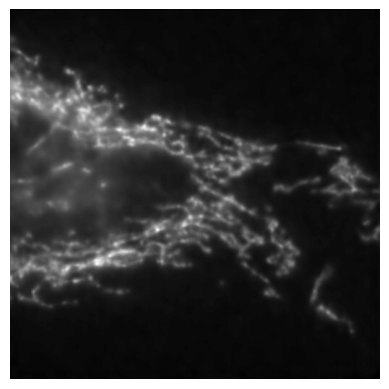

In [19]:
# Affichage de l'image avec matplotlib 
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')
plt.savefig('image_debruitee.png', bbox_inches='tight', pad_inches=0)
